In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

### Задача 16

По описанию условий посева предсказать прорастут семена растений или нет. Провести бинарную классификацию семян с помощью метода Парзеновского окна. Построить график зависимости ошибки на контроле от ширины окна. Подобрать оптимальную ширину окна.

In [2]:
columns = ['season',  'age', 'childish diseases', 'accident',  'surgical intervention', 'high fevers', 
'frequency of alcohol consumption', 'smoking habit', 'number of hours spent sitting per day', 'output']

In [3]:
df = pd.read_csv('fertility_Diagnosis.txt', names = columns)
df['output'] = df['output'] == 'N'
df.head()

,season,age,childish diseases,accident,surgical intervention,high fevers,frequency of alcohol consumption,smoking habit,number of hours spent sitting per day,output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,True
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,False
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,True
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,True
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,False


In [4]:
len(df)

100

In [5]:
np.sum(df['output'])

88

In [6]:
df.astype(float).cov()['output']

season                                  -0.050069
age                                     -0.004566
childish diseases                        0.004444
accident                                 0.023030
surgical intervention                   -0.008889
high fevers                              0.023030
frequency of alcohol consumption         0.007919
smoking habit                           -0.012121
number of hours spent sitting per day   -0.001398
output                                   0.106667
Name: output, dtype: float64

In [127]:
df = df[['season', 'accident', 'high fevers', 'smoking habit', 'output']]

С самого начала мочется объединить признаки 'Season' и 'age', создав один временной ряд, но это будет не совсем корректно: в первом случае имеем периодическое явление, а во втором графа "год" соответствует скорее категориальному признаку: был ли тот или иной год благоприятным для растений, скорее, независимая случайная величина. Но откажемся и от перехода к категриальным признакам: это слишком сильно повысит размерность нашего простанства.

In [7]:
X = df.drop('output', axis = 1)
y = df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [8]:
epan = lambda r : 3 / 4 * (1 - r ** 2) * (np.abs(r) <= 1)
square = lambda r : 15 / 16 * (1 - r ** 2) ** 2 * [np.abs(r) <= 1]
triangle = lambda r :  (1 - np.abs(r)) * [np.abs(r) <= 1]
gaussean = lambda r : (2 * np.pi) ** (-1 / 2) * np.exp(-1 / 2 * r ** 2)
rectangular = lambda r : 0.5 * (np.abs(r) <= 1)
kernels = [epan, square, triangle, gaussean, rectangular]
kernel_names = ['epan', 'square', 'triangle', 'gaussean', 'rectangular']

In [9]:
h =  5
dist_l2 = lambda x, x1 : (np.linalg.norm(x - x1)) ** 2

def get_dencity(members, x, h=2, K=epan):
    dists = np.array([dist_l2(u, x) for u in members.values])
    return np.sum(K(dists / h))

def predict_single(x, h=2, K=epan):
    subclasses = [X_train[y_train], X_train[~y_train]]
    dencity = np.array([get_dencity(members, x, h, K) for members in subclasses])
    dencity /= np.sum(dencity) # На самом деле, эта строчка не имеет никакого алгоритмического смысла       
    return dencity[0] >= dencity[1]

def predict(values, h=2, K=epan):
    return np.array([predict_single(x, h, K) for x in values])

In [10]:
predicted = predict(X_test.values, 3)
accuracy = np.sum(predicted == y_test) / len(y_test)
accuracy 

0.8857142857142857

In [13]:
print(prediction)
print(list(y_test))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False]


Что же, видим очевидную проблему: за счет того, что значений false в выборке весьма мало,
у нас ответы практически всегда - только true. Посмотрим, что можно с этим зделать.

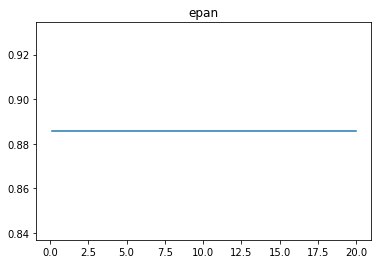

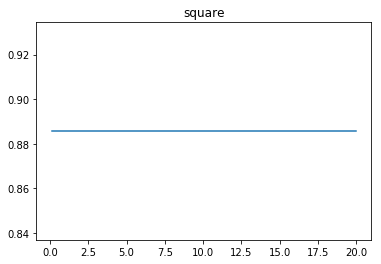

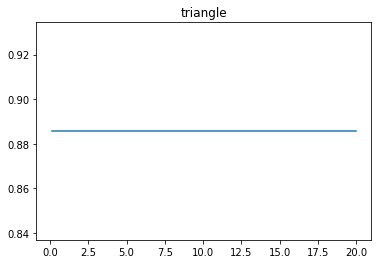

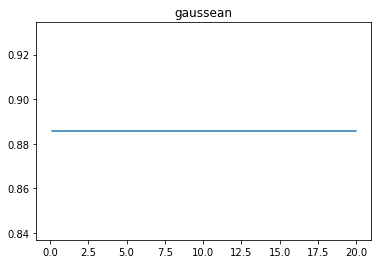

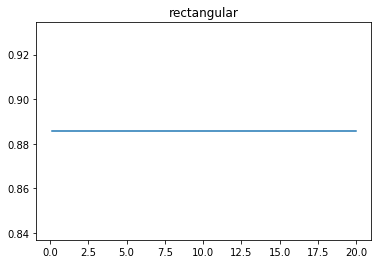

In [14]:
h_es = np.linspace(0.1, 20, 10)

for kernel, name in zip(kernels, kernel_names):
    accuracies = []
    for h in h_es:
        prediction = predict(X_test.values, h, K=kernel)
        loss = np.sum(prediction == y_test) / len(y_test)
        accuracies.append(accuracy)
    plt.title(name)
    plt.plot(h_es, accuracies)
    plt.show()

Видим, что длина окна практически никак нас не спасает: нужно, во-первых, прожумывать метрику растояний между различными элементами выборки, во-вторых, увеличивать саму выборку, потому что умерших растений просто недостаточно. Ну, или искать багу)

In [66]:
from scipy.spatial import distance_matrix
dists = distance_matrix(X_train, X_test, p=2)
len(X_train), len(X_test), dists.shape

In [73]:
distspos = dists[y_train]
distsneg = dists[~y_train]

In [84]:
h = 3
pos = np.sum(epan(pd.DataFrame(distspos) / h), axis = 0)
neg = np.sum(epan(pd.DataFrame(distsneg) / h), axis = 0)

In [91]:
list(pos + neg) * (y_test - 0.5) * 2

83    27.091067
53    23.283250
70   -22.227325
45    25.909058
44    24.535367
39    27.965267
22    24.030467
80    26.909150
10    17.491483
0     26.632017
18    15.508817
30    25.018083
73    25.020250
33    24.699300
90    27.460717
4    -30.529850
76    25.578825
77    23.919642
12    15.642150
31    25.208483
55    22.595183
88    30.218367
26   -25.161667
42    13.029758
69    24.107142
15    15.235283
40    18.196525
96    28.939158
9     25.114350
72    22.949808
11    23.969158
47    21.009083
85    20.970942
28    21.663275
93   -30.957950
Name: output, dtype: float64

In [108]:
df[df['output']].mean()

season                                  -0.135227
age                                      0.663864
childish diseases                        0.875000
accident                                 0.465909
surgical intervention                    0.500000
high fevers                              0.215909
frequency of alcohol consumption         0.840909
smoking habit                           -0.363636
number of hours spent sitting per day    0.405227
output                                   1.000000
dtype: float64

In [109]:
df[~df['output']].mean()

season                                   0.334167
age                                      0.706667
childish diseases                        0.833333
accident                                 0.250000
surgical intervention                    0.583333
high fevers                              0.000000
frequency of alcohol consumption         0.766667
smoking habit                           -0.250000
number of hours spent sitting per day    0.418333
output                                   0.000000
dtype: float64